# Libraries

In [2]:
import numpy as np
import pickle
import os
# Change directory to the root of the folder (this script was launched from the subfolder python_scripts)
# All utils presuppose that we are working from the root directory of the github folder
os.chdir("../")
import sys
# Add utils directory in the list of directories to look for packages to import
sys.path.insert(0, os.path.join(os.getcwd(),'utils'))
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from datetime import datetime
import joblib
import gzip
import csv
import fnmatch
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import cld3
from iso639 import languages
import re
import random

In [3]:
# local utils
from powerlaw_regr import *
from analyse_sequence import *
from find_files_with_pattern import *

In [4]:
# DEFAULT PARAMETERS IN THE FIGURES TO BE ADJUSTED!!!!

plt.style.use("default")

multiplicator = 4
width_fig = 5.70978 * multiplicator # default text width in Comnet is 5.70978
height_fig = width_fig * 2 / 3


params_default = {
    # no upper and right axes
    'axes.spines.right' : False,
    'axes.spines.top' : False,
    # no frame around the legend
    "legend.frameon" : False,

    # dimensions of figures and labels
    # we will play with these once we see how they are rendered in the latex
    'figure.figsize' : (width_fig, height_fig),

    'axes.labelsize' : 8 * multiplicator, #22,
    'axes.titlesize' : 8 * multiplicator, #25,
    'xtick.labelsize' : 6 * multiplicator, #18,
    'ytick.labelsize' : 6 * multiplicator, #18,
    'legend.fontsize' : 6 * multiplicator, #16,
    'font.size' : 8 * multiplicator,

    # no grids (?)
    'axes.grid' : False,

    # the default color(s) for lines in the plots: in order if multiple lines. We can change them or add colors if needed
#     'axes.prop_cycle' : mpl.cycler(color=["#00008B", "#BF0000", "#006400"]), 

    # default quality of the plot. Not too high but neither too low
    "savefig.dpi" : 100,
    "savefig.bbox" : 'tight', 
    
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
#     'text.usetex' : True,
#     'text.latex.preamble': r"\usepackage{amsmath}",
}

plt.rcParams.update(params_default)

In [5]:
# prune text from punctuation and junk...
wnl = WordNetLemmatizer()
pattern = re.compile(r'\B#\w*[A-Za-z]+\w*|\b\w*[A-Za-z]+\w*', re.UNICODE)
def lemmatize(doc):
    '''
        Takes a string doc and returns the list of words, without punctuation and junk
    '''
    l = [wnl.lemmatize(t) for t in pattern.findall(doc)]
    return [w.lower() for w in l if len(w) > 1]

# Last.fm - 1k (O.Celma)

## 1st processing: time ordering

In [9]:
file_path = "./data/ocelma-dataset/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv"

In [ ]:
df_lastfm = pd.read_csv(file_path, sep="\t", 
#                       converters={'timestamp':pd.to_datetime},
#                       parse_dates=['timestamp'],
#                       date_parser=my_date_parser,
#                       infer_datetime_format=True, date_parser=["timestamp"],
                      error_bad_lines=False, quoting=3, lineterminator="\n", 
                names=["userid", "timestamp", "musicbrainz-artist-id", "artist-name", "musicbrainz-track-id", "track-name"])

In [ ]:
my_format="%Y-%m-%dT%H:%M:%SZ"


def lookup(date_pd_series, format=None):
    """
    This is mostly useful for repeated timestamps, otherwise mostly useless.
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in tqdm(date_pd_series.unique())}
    return date_pd_series.map(dates)
df_lastfm['timestamp'] = lookup(df_lastfm['timestamp'], format=my_format)

In [93]:
df_lastfm.iloc[7727675]

userid                                            user_000405
timestamp                                2010-08-13T23:06:38Z
musicbrainz-artist-id    5f572b31-8fd9-45ae-9beb-358c98d839df
artist-name                                 The Dandy Warhols
musicbrainz-track-id     223f9324-3546-446b-96a2-5f663192dd42
track-name                                              Sleep
Name: 7727675, dtype: object

In [76]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_orig.pkl", "wb") as fp:
    joblib.dump(df_lastfm, fp)

In [86]:
df_lastfm = df_lastfm.sort_values(['timestamp', "userid"])

In [87]:
df_lastfm.head()

,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
7589788,user_000391,2005-02-14 00:00:07,fbd86487-ccb5-4a57-a860-cc3d360b5115,Starsailor,6b4977f4-3c7a-492a-af61-1e877fa66f52,Love Is Here
16931166,user_000871,2005-02-14 00:00:38,b3a6ebdf-4ee6-4ec0-912c-be03ade6c833,Sui Generis,9ecc2ab3-7294-43ad-bdeb-f51388a7a6e0,Rasguña Las Piedras
13542781,user_000709,2005-02-14 00:01:44,b4d32cff-f19e-455f-86c4-f347d824ca61,Eurythmics,1d0f1ea5-0a92-4578-a7e7-3f2a7129da61,Love Is A Stranger
5604026,user_000285,2005-02-14 00:02:10,95e1ead9-4d31-4808-a7ac-32c3614c116b,The Killers,46909ba9-46c7-461e-a2ef-280eacd550e4,Jenny Was A Friend Of Mine
2882463,user_000142,2005-02-14 00:02:40,51086134-0896-4c00-b54a-c5c37aeaf2bf,Anton Maiden,14025355-94c2-4e9b-b63f-c16cab9e8086,Revelations


In [96]:
df_lastfm.tail(20)

,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
12052920,user_000650,2009-06-19 20:34:15,cd84f520-7cd7-4e47-8cab-7beeceec3210,Alyson,NaN,Here With Me
18503194,user_000960,2009-06-19 20:35:33,299278d3-25dd-4f30-bae4-5b571c28034d,The Postal Service,NaN,Umbrella
18503193,user_000960,2009-06-19 20:40:16,0c751690-c784-4a4f-b1e4-c1de27d47581,Animal Collective,50f16fa4-501b-4883-8932-fb273238947c,Grass
13793249,user_000724,2009-06-19 20:42:49,f91e3a88-24ee-4563-8963-fab73d2765ed,Franz Schubert,2f685a84-9745-447c-a3a0-8f1d107bc7c2,"Piano Sonata No.20 In A, D.959: Ii. Andantino"
18503192,user_000960,2009-06-19 20:43:18,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,Death Cab For Cutie,5e26d283-96c1-4fbc-a24c-9866953f563c,I Will Possess Your Heart
13793248,user_000724,2009-06-19 20:50:23,f91e3a88-24ee-4563-8963-fab73d2765ed,Franz Schubert,bd2ff722-fa0b-4090-accb-1fec7b429bb7,"Piano Sonata No.20 In A, D.959: Iii. Scherzo (..."
18503191,user_000960,2009-06-19 20:51:53,28b2fb52-a83a-40ec-8617-6436e26eb3fd,Apostle Of Hustle,ca734922-ffc2-41be-8d53-5bdc15be90e2,¡Rafaga!
16392625,user_000842,2009-06-19 20:55:45,f91e3a88-24ee-4563-8963-fab73d2765ed,Franz Schubert,91aedc56-8a2d-4ca2-96b9-8d014ab92b94,"Piano Sonata No.20 In A, D.959: Iv. Rondo (All..."
18503190,user_000960,2009-06-19 20:55:51,299278d3-25dd-4f30-bae4-5b571c28034d,The Postal Service,NaN,Take A Look At Me Now
18503189,user_000960,2009-06-19 21:00:06,9a58fda3-f4ed-4080-a3a5-f457aac9fcdd,Joy Division,f83d07eb-05d0-4d7b-a4a4-4139b6815ce2,Atrocity Exhibition


In [90]:
print(df_lastfm.iloc[0]["timestamp"], df_lastfm.iloc[1]["timestamp"] )
print(df_lastfm.iloc[-1]["timestamp"], df_lastfm.iloc[-2]["timestamp"] )

2005-02-14 00:00:07 2005-02-14 00:00:38
2013-09-29 18:32:04 2010-08-13 23:06:38


In [95]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_time_ordered.pkl", "wb") as fp:
    joblib.dump(df_lastfm, fp)

In [42]:
df = df.reset_index(drop=True)

Last two rows must be dropped, because time is completely different than the previous ones. 

Also this dataframe has a time interval different than the one said by the author on the website.

In [43]:
df_lastfm = df_lastfm.drop([19150866,19150867])

In [44]:
df_lastfm

,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
0,user_000391,2005-02-14 00:00:07,fbd86487-ccb5-4a57-a860-cc3d360b5115,Starsailor,6b4977f4-3c7a-492a-af61-1e877fa66f52,Love Is Here
1,user_000871,2005-02-14 00:00:38,b3a6ebdf-4ee6-4ec0-912c-be03ade6c833,Sui Generis,9ecc2ab3-7294-43ad-bdeb-f51388a7a6e0,Rasguña Las Piedras
2,user_000709,2005-02-14 00:01:44,b4d32cff-f19e-455f-86c4-f347d824ca61,Eurythmics,1d0f1ea5-0a92-4578-a7e7-3f2a7129da61,Love Is A Stranger
3,user_000285,2005-02-14 00:02:10,95e1ead9-4d31-4808-a7ac-32c3614c116b,The Killers,46909ba9-46c7-461e-a2ef-280eacd550e4,Jenny Was A Friend Of Mine
4,user_000142,2005-02-14 00:02:40,51086134-0896-4c00-b54a-c5c37aeaf2bf,Anton Maiden,14025355-94c2-4e9b-b63f-c16cab9e8086,Revelations
...,...,...,...,...,...,...
19150861,user_000960,2009-06-19 21:18:26,09037f07-42bc-46ac-a1ee-37f834451fee,Minor Threat,5ec37b8c-1e83-46b2-8c6f-83f4923435a7,No Reason
19150862,user_000960,2009-06-19 21:20:24,3f542031-b054-454d-b57b-812fa2a81b11,Yo La Tengo,9fb737f7-dc19-452d-983e-83812612b3b5,A Worrying Thing
19150863,user_000960,2009-06-19 21:23:17,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,Death Cab For Cutie,4e17b118-70a6-4c1f-b326-b4ce91fd3fad,Soul Meets Body
19150864,user_000960,2009-06-19 21:27:08,5cbef01b-cc35-4f52-af7b-d0df0c4f61b9,Sonic Youth,af847770-3a91-4ecd-912c-ce154b5fce6a,Superstar


In [45]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_time_ordered_clean.pkl", "wb") as fp:
    joblib.dump(df_lastfm, fp)

## 2nd processing: indexing tracks and artists

In [39]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_time_ordered_clean.pkl", "rb") as fp:
    df_lastfm = joblib.load(fp)

In [45]:
artists = df_lastfm[["musicbrainz-artist-id","artist-name"]]

artists_unique = artists.drop_duplicates()

artists_unique = artists_unique.reset_index(drop=True)

In [46]:
unique_artists_remap = {}
for i in tqdm(range(len(artists_unique))):
    row = artists_unique.loc[i]
    artist_id = row["musicbrainz-artist-id"]
    if not pd.notna(artist_id):
        artist_id = None
    artist_name = row["artist-name"]
    if not pd.notna(artist_name):
        artist_name = None
    unique_artists_remap[(artist_id,artist_name)] = i

100%|██████████| 177023/177023 [00:24<00:00, 7298.38it/s]


In [40]:
tracks = df_lastfm[["musicbrainz-track-id","track-name","musicbrainz-artist-id","artist-name"]]

In [41]:
tracks_unique = tracks.drop_duplicates()

In [42]:
tracks_unique = tracks_unique.reset_index(drop=True)
# tracks_unique["index"] = tracks_unique.

In [86]:
# unique_tracks_remap = {}
# for i in tqdm(range(len(tracks_unique))):
#     row = tracks_unique.loc[i]
#     unique_tracks_remap[(row["musicbrainz-track-id"],row["track-name"],row["musicbrainz-artist-id"],row["artist-name"])] = i

In [48]:
unique_tracks_remap = {}
for i in tqdm(range(len(tracks_unique))):
    row = tracks_unique.loc[i]
    track_id = row["musicbrainz-track-id"]
    if not pd.notna(track_id):
        track_id = None
    track_name = row["track-name"]
    if not pd.notna(track_name):
        track_name = None
    artist_id = row["musicbrainz-artist-id"]
    if not pd.notna(artist_id):
        artist_id = None
    artist_name = row["artist-name"]
    if not pd.notna(artist_name):
        artist_name = None
    artist_id_remapped = unique_artists_remap[(artist_id,artist_name)]
    unique_tracks_remap[(track_id,track_name,artist_id_remapped)] = i

100%|██████████| 1505514/1505514 [03:45<00:00, 6662.75it/s]


In [49]:
df_lastfm2 = df_lastfm[["userid","timestamp"]]
track_id_remapped_list = -np.ones(len(df_lastfm2))
artist_id_remapped_list = -np.ones(len(df_lastfm2))

In [50]:
for i in tqdm(range(len(df_lastfm))):
    row = df_lastfm.loc[i]
    track_id = row["musicbrainz-track-id"]
    if not pd.notna(track_id):
        track_id = None
    track_name = row["track-name"]
    if not pd.notna(track_name):
        track_name = None
    artist_id = row["musicbrainz-artist-id"]
    if not pd.notna(artist_id):
        artist_id = None
    artist_name = row["artist-name"]
    if not pd.notna(artist_name):
        artist_name = None
    artist_id_remapped = unique_artists_remap[(artist_id,artist_name)]
    artist_id_remapped_list[i] = artist_id_remapped
    track_id_remapped_list[i] = unique_tracks_remap[(track_id,track_name,artist_id_remapped)]

100%|██████████| 19150866/19150866 [1:28:24<00:00, 3610.16it/s]


In [51]:
df_lastfm2["track_id_remapped"] = track_id_remapped_list.copy()
df_lastfm2["artist_id_remapped"] = artist_id_remapped_list.copy()

/tmp/2049703.1.all.q/ipykernel_20116/1589433352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["track_id_remapped"] = track_id_remapped_list.copy()
/tmp/2049703.1.all.q/ipykernel_20116/1589433352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["artist_id_remapped"] = artist_id_remapped_list.copy()


In [52]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/remap_artists.pkl", "wb") as fp:
    joblib.dump(unique_artists_remap, fp)
with open("./data/ocelma-dataset/lastfm-dataset-1K/remap_tracks.pkl", "wb") as fp:
    joblib.dump(unique_tracks_remap, fp)

In [53]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_indexed.pkl", "wb") as fp:
    joblib.dump(df_lastfm2, fp)

In [54]:
df_lastfm = df_lastfm2.copy()

## 3rd processing: creation of individual sequences

In [281]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_indexed.pkl", "rb") as fp:
    df_lastfm = joblib.load(fp)

In [282]:
users_list = list(df_lastfm["userid"].unique())
users_list.sort()
print(len(users_list), max(users_list))

992 user_001000


In [283]:
df_lastfm

,userid,timestamp,track_id_remapped,artist_id_remapped
0,user_000391,2005-02-14 00:00:07,0.0,0.0
1,user_000871,2005-02-14 00:00:38,1.0,1.0
2,user_000709,2005-02-14 00:01:44,2.0,2.0
3,user_000285,2005-02-14 00:02:10,3.0,3.0
4,user_000142,2005-02-14 00:02:40,4.0,4.0
...,...,...,...,...
19150861,user_000960,2009-06-19 21:18:26,73214.0,2842.0
19150862,user_000960,2009-06-19 21:20:24,117991.0,2228.0
19150863,user_000960,2009-06-19 21:23:17,103131.0,126.0
19150864,user_000960,2009-06-19 21:27:08,25733.0,346.0


In [284]:
users = {}
for userid in users_list:
    users[userid] = {"sequence_tracks":[], "sequence_artists":[], "sequence_timestamps":[]}

In [ ]:
for i in tqdm(range(len(df_lastfm))):
    row = df_lastfm.loc[i]
    userid = row["userid"]
    if not pd.notna(userid):
        print(f"Row {i}: userid None")
        userid = None
    timestamp = row["timestamp"]
    if not pd.notna(timestamp):
        print(f"Row {i}: timestamp None")
        timestamp = None
    track_id = row["track_id_remapped"]
    if not pd.notna(track_id):
        print(f"Row {i}: track_id None")
        track_id = None
    artist_id = row["artist_id_remapped"]
    if not pd.notna(artist_id):
        print(f"Row {i}: artist_id None")
        artist_id = None
    users[userid]["sequence_tracks"].append(track_id)
    users[userid]["sequence_artists"].append(artist_id)
    users[userid]["sequence_timestamps"].append(timestamp)

In [63]:
for userid in tqdm(users_list):
    users[userid]["sequence_tracks"] = np.array(users[userid]["sequence_tracks"],dtype=int)
    users[userid]["sequence_artists"] = np.array(users[userid]["sequence_artists"],dtype=int)
    users[userid]["sequence_timestamps"] = np.array(users[userid]["sequence_timestamps"])

100%|██████████| 992/992 [00:00<00:00, 14418.21it/s]


In [64]:
i = users_list[0]
print(users[i]["sequence_tracks"][:20])
print(users[i]["sequence_tracks"][-20:])
print(users[i]["sequence_artists"][:20])
print(users[i]["sequence_artists"][-20:])
print(users[i]["sequence_timestamps"][:20])
print(users[i]["sequence_timestamps"][-20:])

[447195 447199 447208 447212 447213 447218  79351  70436   2677 410222
 447267 447272 447276  63867 314911  73796 352588 108352 447301  41303]
[1456541  514060   53426 1251851 1161644 1161658 1477073 1477076 1477082
  241971 1477101 1477242 1476972 1476987 1476992 1477268 1476995 1477004
 1477011 1496528]
[55741 55741 55741  6657 14330  7290  7290   284   299  4638 55749 20455
 55750   464   464   779 12480   407 17380  1691]
[169814  16914   9673    323   1139   1139   6625   6625   6625   6625
   6625   6625   6625   6625   6625   6625   6625   6625   6625   2969]
[Timestamp('2006-08-13 13:59:20') Timestamp('2006-08-13 14:03:29')
 Timestamp('2006-08-13 14:10:43') Timestamp('2006-08-13 14:17:40')
 Timestamp('2006-08-13 14:19:06') Timestamp('2006-08-13 14:23:03')
 Timestamp('2006-08-13 14:44:23') Timestamp('2006-08-13 14:55:14')
 Timestamp('2006-08-13 14:59:59') Timestamp('2006-08-13 15:05:20')
 Timestamp('2006-08-13 15:07:25') Timestamp('2006-08-13 15:12:12')
 Timestamp('2006-08-13 15

In [291]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users.pkl.gz", "wb") as fp:
    joblib.dump(users, fp)

In [6]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users.pkl.gz", "rb") as fp:
    users = joblib.load(fp)

In [10]:
# save single files in a specific folder
raw_folder = "./data/ocelma-dataset/lastfm-dataset-1K/raw_sequences/"
os.makedirs(raw_folder, exist_ok = True)
for userid, user_dict in tqdm(users.items()):
    with gzip.open(os.path.join(raw_folder,f"{userid}.pkl.gz"), "wb") as fp:
        pickle.dump(user_dict, fp)

  0%|          | 0/992 [00:00<?, ?it/s]

In [292]:
min_len_sequence = 1000
# filtering on all users with at least 1000 elements in the sequence
users_list_filtered = []
for userid in tqdm(users_list):
    if len(users[userid]["sequence_tracks"]) < min_len_sequence:
        del users[userid]
    else:
        users_list_filtered.append(userid)
print("Kept %d out of %d"%(len(users_list_filtered), len(users_list)))

  0%|          | 0/992 [00:00<?, ?it/s]

Kept 890 out of 992


In [293]:
# from now on this will be used instead
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_min_1000.pkl.gz", "wb") as fp:
    joblib.dump(users, fp)

In [294]:
users_list = users_list_filtered

In [17]:
# from now on this will be used instead
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_list_min_1000.pkl.gz", "wb") as fp:
    joblib.dump(users_list, fp)

## Analysis

In [5]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_min_1000.pkl.gz", "rb") as fp:
    users = joblib.load(fp)

In [6]:
users_list = list(users.keys())
users_list.sort()
print(len(users_list), max(users_list))

890 user_001000


In [9]:
# Just a check here
# If there is a sequence_labels with max counts of each labels = 2 there might be a problem during entropy calculation!
for userid in tqdm(users_list):
    sequence_labels = users[userid]["sequence_artists"]
    labels_freq = {}
    for t,label in enumerate(sequence_labels):
        if label not in labels_freq:
            labels_freq[label] = 1
        else:
            labels_freq[label] += 1
    if max(list(labels_freq.values())) < 10:
        print(userid,max(list(labels_freq.values())))

100%|██████████| 890/890 [00:09<00:00, 94.12it/s] 


### Individual analysis

In [ ]:
# userid = users_list[60]
results_light_individual_lastfm = {} 
for userid in tqdm(users_list):
    sequence = users[userid]["sequence_tracks"]
    sequence_labels = users[userid]["sequence_artists"]
    save_light_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_light/{userid}_light.pkl"
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results/{userid}.pkl"
    save_entropies_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_entropy/{userid}.pkl"
    results_light_individual_lastfm[userid] = analyse_sequence(sequence, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         save_entropies_file_path = save_entropies_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

  0%|          | 0/890 [00:00<?, ?it/s]

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
print("FINISHED")

In [60]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/results_light_users_lastfm.pkl.gz", "wb") as fp:
    joblib.dump(results_light_individual_lastfm, fp)

In [ ]:
# USE THIS TIME THE SEQUENCE OF ARTISTS FOR THE SEQUENCES
results_light_individual_lastfm = {} 
for userid in tqdm(users_list):
    sequence = users[userid]["sequence_artists"]
    sequence_labels = users[userid]["sequence_artists"]
    save_light_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists_light/{userid}_light.pkl"
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists/{userid}.pkl"
    save_entropies_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists_entropy/{userid}.pkl"
    results_light_individual_lastfm[userid] = analyse_sequence(sequence, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         save_entropies_file_path = save_entropies_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [62]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/results_light_users_lastfm_artists.pkl.gz", "wb") as fp:
    joblib.dump(results_light_individual_lastfm, fp)

### Average individual analysis

In [18]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_min_1000.pkl.gz", "rb") as fp:
    users = joblib.load(fp)

In [25]:
users_list = list(users.keys())
users_list.sort()
print(len(users_list), max(users_list))

890 user_001000


In [19]:
users['user_000001'].keys()

dict_keys(['sequence_tracks', 'sequence_artists', 'sequence_timestamps'])

In [20]:
min_len_sequence = 1000

890


  0%|          | 0/890 [00:00<?, ?it/s]

Excluding 0% len is 1021
Excluding 10% len is 2500
Excluding 20% len is 4530
Excluding 30% len is 7078
Excluding 40% len is 10297
Excluding 50% len is 13971
Excluding 60% len is 18354
Excluding 70% len is 23465
Excluding 80% len is 34738
Excluding 90% len is 48223
Excluding 100% len is 183103


[]

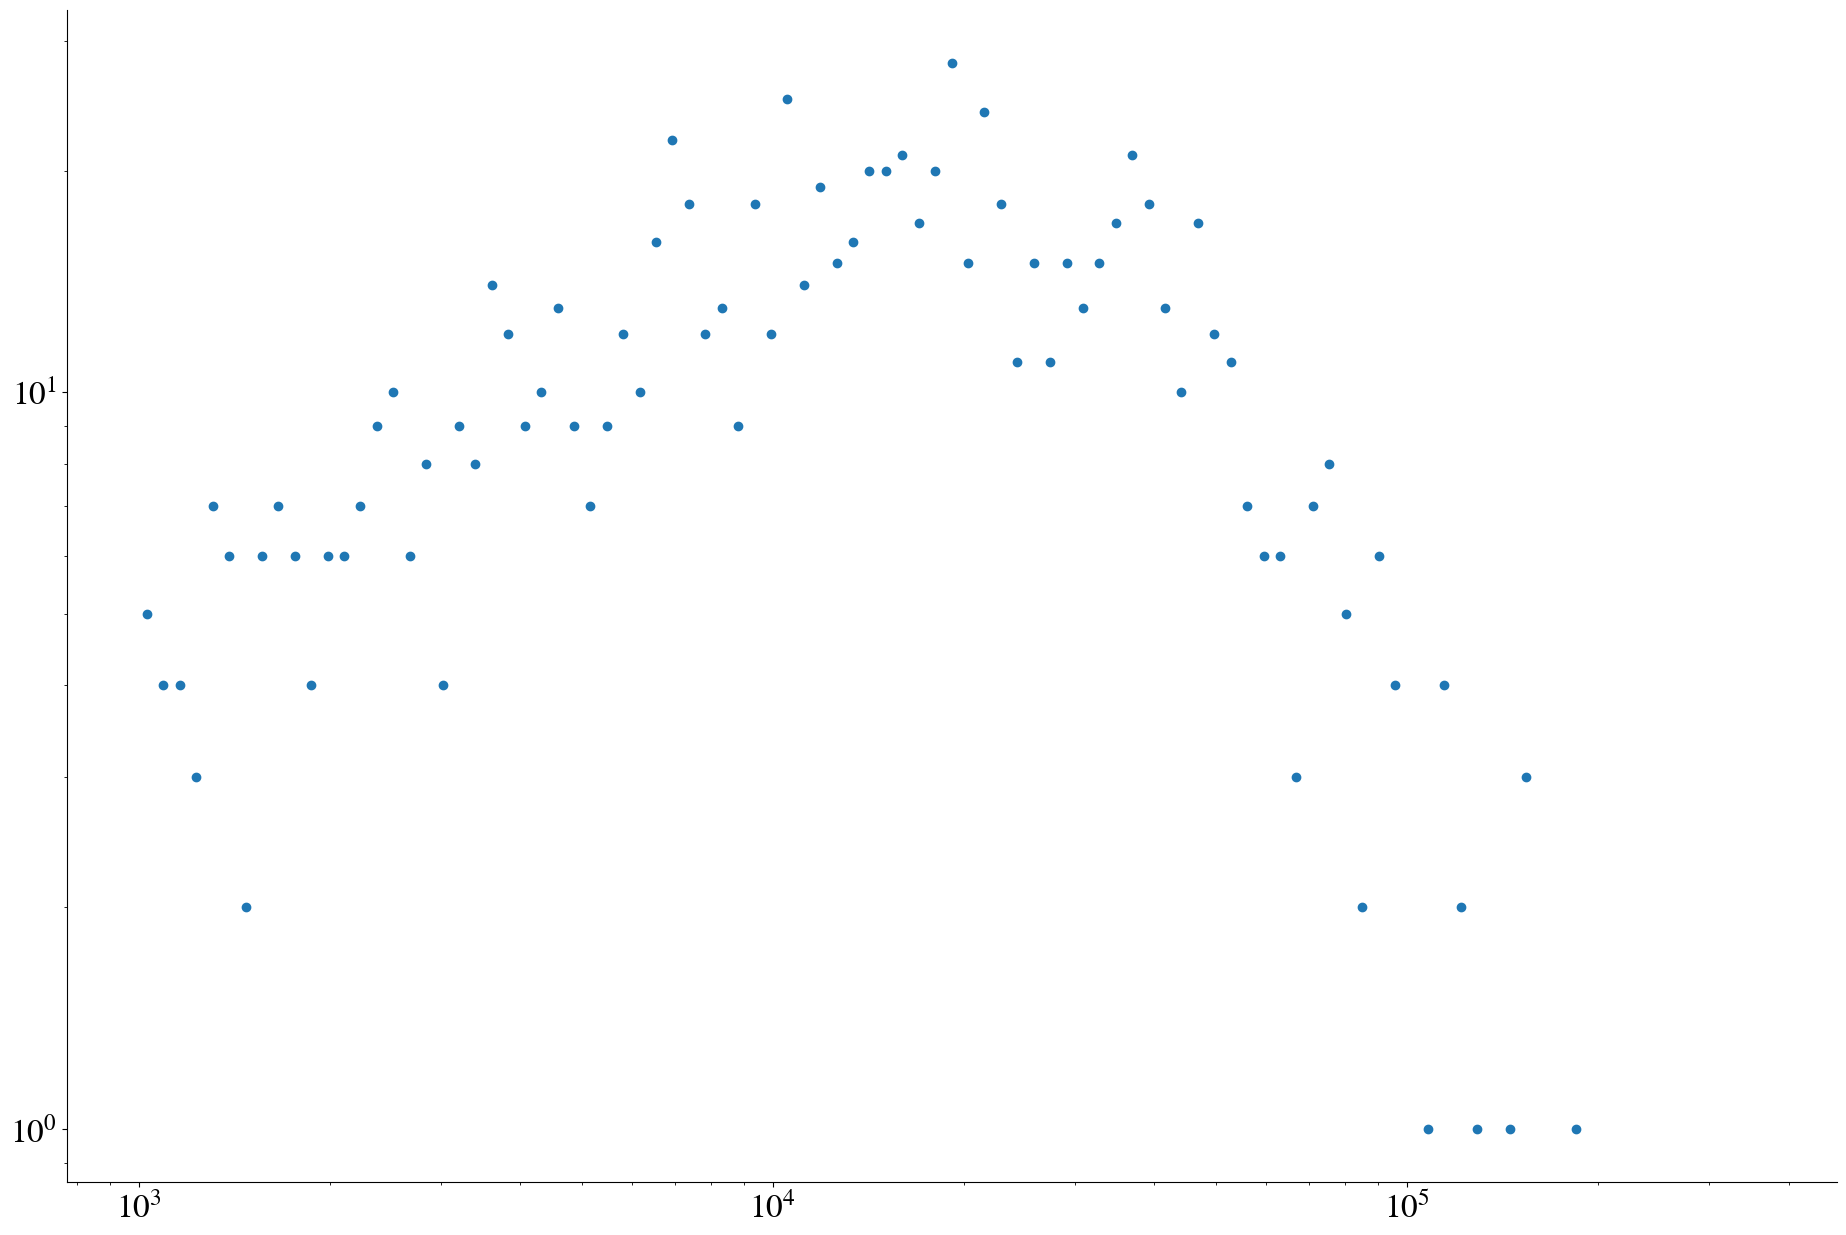

In [78]:
len_sequences = {}
len_sequences_to_sort = []
num_users = len(users)
print(num_users)
for ID, user in tqdm(users.items()):
    sequence = user["sequence_tracks"]
    sequence_labels = user["sequence_artists"]
    len_sequences[ID] = len(sequence)
    len_sequences_to_sort.append((len(sequence), ID))
len_sequences_sorted = sorted(len_sequences_to_sort)
for i in range(11):
    print(f'Excluding %d%% len is %d'%(i*10, len_sequences_sorted[int(i/10*(num_users-1))][0]))
vals, bin_edges = np.histogram(list(len_sequences.values()), bins = np.geomspace(min_len_sequence,2*max(list(len_sequences.values())), 100))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.scatter(bin_centers, vals)
plt.loglog()

[]

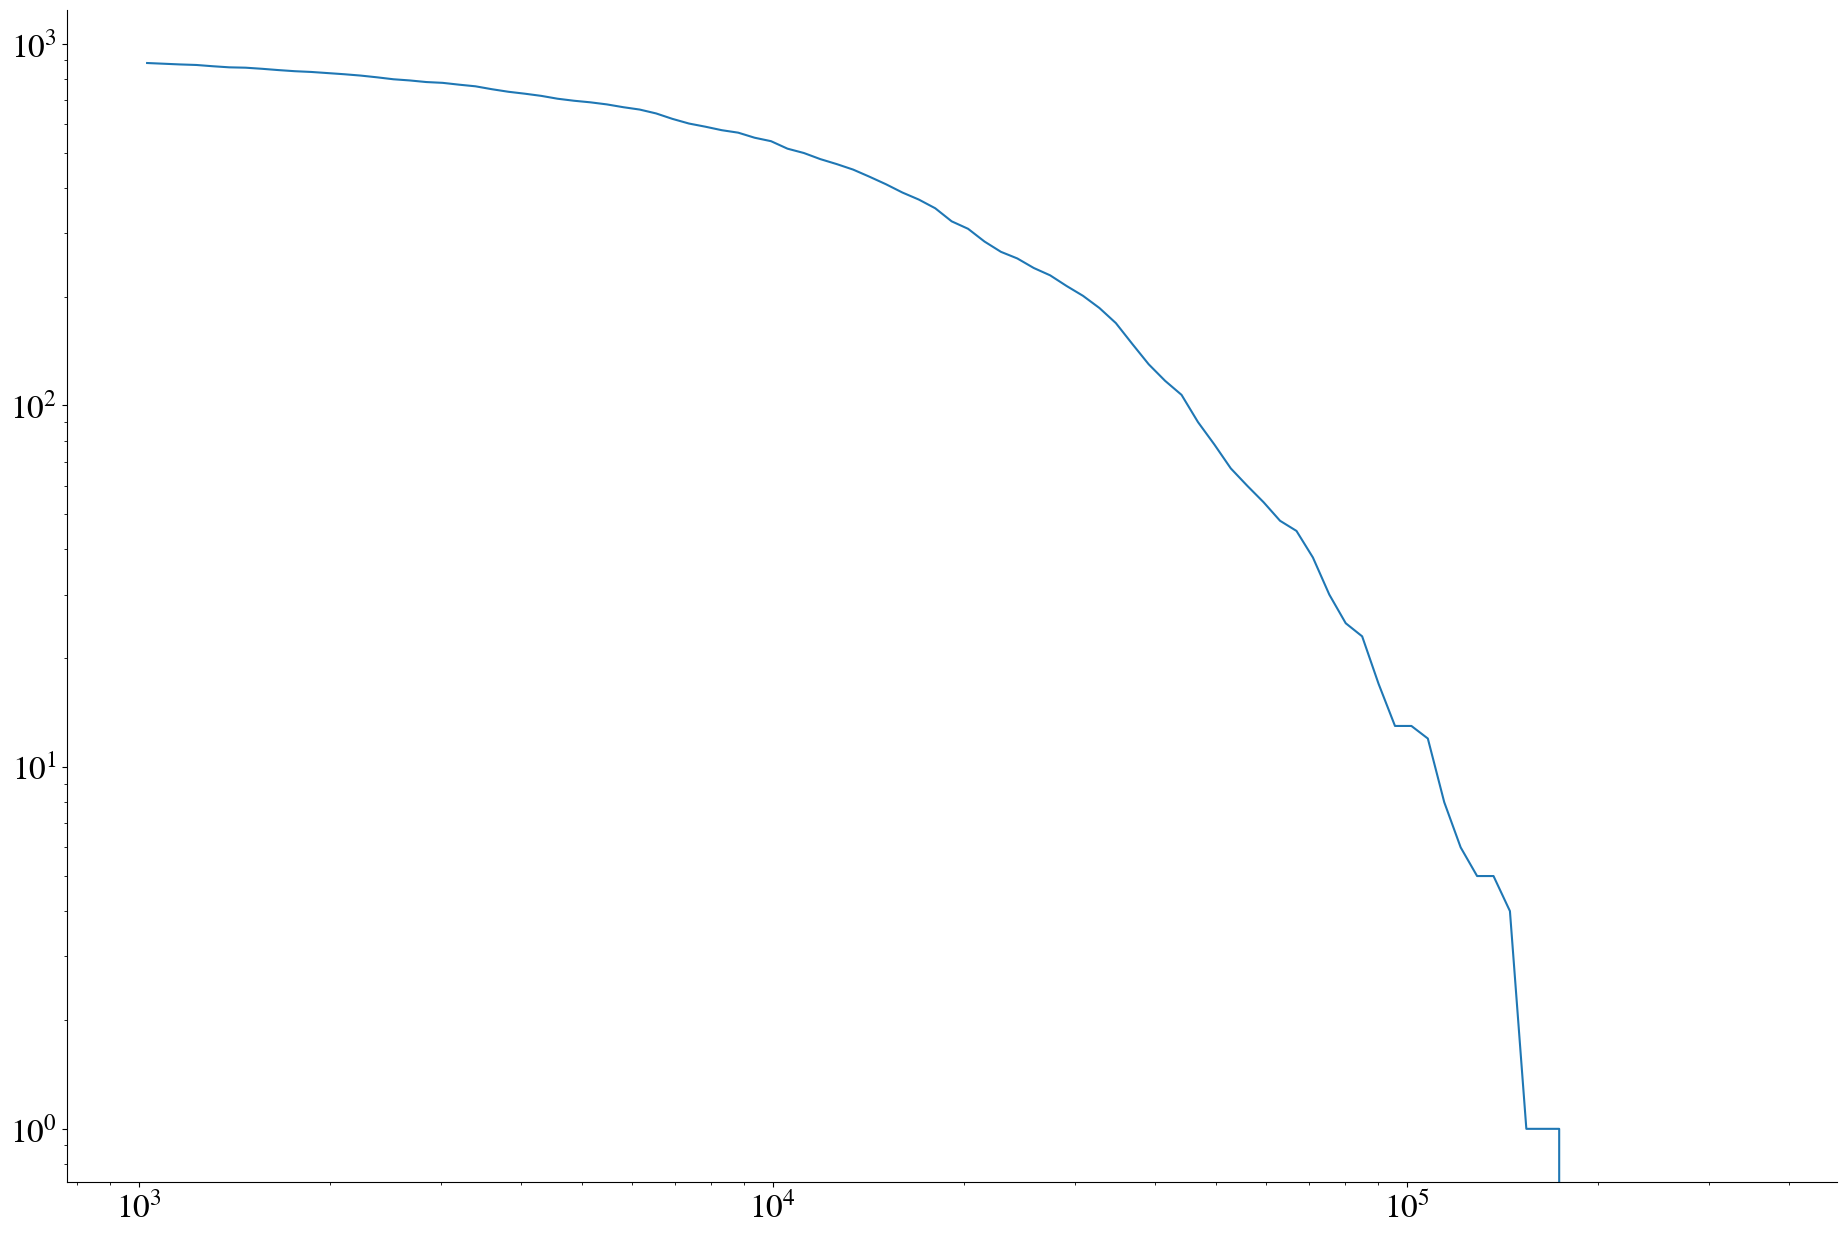

In [79]:
cum = 0
cum_vals = []
sum_vals = sum(vals)
for val in vals:
    cum += val
    cum_vals.append(sum_vals - cum)
plt.plot(bin_centers, cum_vals)
plt.loglog()

In [80]:
median_len_sequences = int(np.round(np.median(list(len_sequences.values()))))
print("Median len of the sequences is",median_len_sequences)

Median len of the sequences is 13985


In [81]:
average_user = {
    'D': [], 
    'D2': [], 
    'D3': [], 
    'D4': [], 
}
count = 0
for userid in tqdm(users_list):
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results/{userid}.pkl"
    save_light_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_light/{userid}_light.pkl"
    with open(save_all_file_path, 'rb') as fp:
        user_result = pickle.load(fp)
    if len(user_result['D']) > median_len_sequences:
        count += 1
        average_user['D'].append(user_result['D'][:median_len_sequences])
        average_user['D2'].append(user_result['D2'][:median_len_sequences])
        average_user['D3'].append(user_result['D3'][:median_len_sequences])
        average_user['D4'].append(user_result['D4'][:median_len_sequences])

for key in ['D', 'D2', 'D3', 'D4']:
    average_user[key] = np.array(average_user[key])
    mean = np.mean(average_user[key], axis=0)
    std = np.std(average_user[key], axis=0)
    average_user[key+'_plus_std'] = mean + std
    average_user[key+'_minus_std'] = mean - std
    average_user[key+'_25_percentile'] = np.percentile(average_user[key], 25, axis=0)
    average_user[key+'_50_percentile'] = np.percentile(average_user[key], 50, axis=0)
    average_user[key+'_75_percentile'] = np.percentile(average_user[key], 75, axis=0)
    average_user[key] = mean

print(count)

  0%|          | 0/890 [00:00<?, ?it/s]

445


In [85]:
D = average_user['D']
D2 = average_user['D2']
D3 = average_user['D3']
D4 = average_user['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join('./data/ocelma-dataset/lastfm-dataset-1K/', f"average_individual_results_light.pkl")
save_all_file_path = os.path.join('./data/ocelma-dataset/lastfm-dataset-1K/', f"average_individual_results.pkl")
average_results_lastfm = analyse_sequence(None, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = True)
os.remove(save_light_file_path)
for key in average_user.keys():
    average_results_lastfm[key] = average_user[key]
with open(save_all_file_path,'wb') as fp:
    pickle.dump(average_results_lastfm,fp)

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [86]:
average_user_artists = {
    'D': [], 
    'D2': [], 
    'D3': [], 
    'D4': [], 
}
count = 0
for userid in tqdm(users_list):
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists/{userid}.pkl"
    save_light_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists_light/{userid}_light.pkl"
    with open(save_all_file_path, 'rb') as fp:
        user_result = pickle.load(fp)
    if len(user_result['D']) > median_len_sequences:
        count += 1
        average_user_artists['D'].append(user_result['D'][:median_len_sequences])
        average_user_artists['D2'].append(user_result['D2'][:median_len_sequences])
        average_user_artists['D3'].append(user_result['D3'][:median_len_sequences])
        average_user_artists['D4'].append(user_result['D4'][:median_len_sequences])

for key in ['D', 'D2', 'D3', 'D4']:
    average_user_artists[key] = np.array(average_user_artists[key])
    mean = np.mean(average_user_artists[key], axis=0)
    std = np.std(average_user_artists[key], axis=0)
    average_user_artists[key+'_plus_std'] = mean + std
    average_user_artists[key+'_minus_std'] = mean - std
    average_user_artists[key+'_25_percentile'] = np.percentile(average_user_artists[key], 25, axis=0)
    average_user_artists[key+'_50_percentile'] = np.percentile(average_user_artists[key], 50, axis=0)
    average_user_artists[key+'_75_percentile'] = np.percentile(average_user_artists[key], 75, axis=0)
    average_user_artists[key] = mean

print(count)

  0%|          | 0/890 [00:00<?, ?it/s]

445


In [87]:
D = average_user_artists['D']
D2 = average_user_artists['D2']
D3 = average_user_artists['D3']
D4 = average_user_artists['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join('./data/ocelma-dataset/lastfm-dataset-1K/', f"average_individual_results_artists_light.pkl")
save_all_file_path = os.path.join('./data/ocelma-dataset/lastfm-dataset-1K/', f"average_individual_results_artists.pkl")
average_results_lastfm_artists = analyse_sequence(None, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = True)
os.remove(save_light_file_path)
for key in average_user_artists.keys():
    average_results_lastfm_artists[key] = average_user_artists[key]
with open(save_all_file_path,'wb') as fp:
    pickle.dump(average_results_lastfm_artists,fp)

### Collective analysis

In [7]:
sequence = []
random_users_list = users_list.copy()
random.shuffle(random_users_list)
for userid in tqdm(random_users_list):
    sequence += list(users[userid]["sequence_tracks"])
sequence = np.array(sequence)

100%|██████████| 890/890 [00:01<00:00, 765.98it/s]


In [8]:
save_light_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/collective_results_light2.pkl"
save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/collective_results2.pkl"

results_light_collective_lastfm = analyse_sequence(sequence, num_to_save=1000, 
                     calculate_entropies_original = False, calculate_entropies_labels = False,
                     D=None, D2=None, D3=None, D4=None, 
                     do_also_D2 = True, do_also_D3 = True, do_also_D4 = False, 
                                                   sequence_labels = None,
                     save_all=True, save_all_file_path = save_all_file_path, 
                     save_light_file_path = save_light_file_path,
                     save_entropies_file_path = "old_to_delete.entropy",
                     calculate_beta_loglogregr_indices = False,
                     do_prints = True, return_all = False)

100%|██████████| 19112984/19112984 [00:15<00:00, 1264740.74it/s]


Sorted indices to save at 2023-07-06 13:56:01.829226
Doing beta_mean_indices at 2023-07-06 13:56:01.832789
Doing geom points loglogregr at 2023-07-06 13:56:01.876098


/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving at 2023-07-06 13:56:13.066550
Finished analysis at 2023-07-06 13:56:13.775472


In [ ]:
sequence_labels = []
random_users_list = users_list.copy()
random.shuffle(random_users_list)
for userid in tqdm(random_users_list):
    sequence_labels += list(users[userid]["sequence_artists"])
sequence_labels = np.array(sequence_labels)

In [10]:
save_light_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/collective_results_artists_light.pkl"
save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/collective_results_artists.pkl"

results_light_collective_lastfm_labels = analyse_sequence(sequence_labels, num_to_save=1000, 
                     calculate_entropies_original = False, calculate_entropies_labels = False,
                     D=None, D2=None, D3=None, D4=None, 
                     do_also_D4 = False, do_also_D3 = True, sequence_labels = None,
                     save_all=True, save_all_file_path = save_all_file_path, 
                     save_light_file_path = save_light_file_path,
                     save_entropies_file_path = "old_to_delete.entropy",
                     calculate_beta_loglogregr_indices = False,
                     do_prints = True, return_all = False)

100%|██████████| 19112983/19112983 [00:13<00:00, 1371311.88it/s]


Sorted indices to save at 2023-07-05 12:48:57.348772
Doing beta_mean_indices at 2023-07-05 12:48:57.354207
Doing geom points loglogregr at 2023-07-05 12:48:57.414004
Saving at 2023-07-05 12:49:12.134519
Finished analysis at 2023-07-05 12:49:13.096111


# Gutenberg

Only consider English books using https://github.com/pgcorpus/gutenberg

In [6]:
data_folder = './data/gutenberg/data/'
analysis_folder = './data/gutenberg/analysis/'
os.makedirs(analysis_folder, exist_ok = True)
text_folder = './data/gutenberg/data/text/'

## Data collection

In [10]:
min_len_sequence = 1000

In [11]:
paths = sorted(find_pattern('*.txt', text_folder))
paths[:10]

['./gutenberg/data/text/PG10000_text.txt',
 './gutenberg/data/text/PG10007_text.txt',
 './gutenberg/data/text/PG1000_text.txt',
 './gutenberg/data/text/PG10012_text.txt',
 './gutenberg/data/text/PG1001_text.txt',
 './gutenberg/data/text/PG1002_text.txt',
 './gutenberg/data/text/PG10031_text.txt',
 './gutenberg/data/text/PG10039_text.txt',
 './gutenberg/data/text/PG1003_text.txt',
 './gutenberg/data/text/PG1004_text.txt']

In [12]:
IDs = [path.split('/')[-1].split('_')[0] for path in paths]
IDs[:10]

['PG10000',
 'PG10007',
 'PG1000',
 'PG10012',
 'PG1001',
 'PG1002',
 'PG10031',
 'PG10039',
 'PG1003',
 'PG1004']

In [ ]:
try:
    raise KeyError
    print('Trying to load word2index and word2stem mapping...')
    with gzip.open(os.path.join(analysis_folder, 'word2index.pkl.gz'), 'rb') as fp:
        word2index = joblib.load(fp)
    with gzip.open(os.path.join(analysis_folder, 'word2stem.pkl.gz'), 'rb') as fp:
        word2stem = joblib.load(fp)
    print('Loaded word2index and word2stem mapping')
except:
    print('Computing word2index and word2stem mapping...')
    all_books = {}
    word2index = {}
    max_index = 0
    word2stem = {}
    stem2index = {}
    max_stem_index = 0
    english_IDs = []
    for path in tqdm(paths):
        ID = path.split('/')[-1].split('_')[0]
        with open(path, 'r') as fp:
            text = fp.read()
        language_prediction = cld3.get_language(text) # technically now they are all english texts, so no need for this
#         if language_prediction.probability > 0.5: # probability > 0.99: # is_reliable == True:
        language = language_prediction.language # This gives a iso639 code
        if language != 'en':
            continue
        language = languages.get(alpha2=language).name # get the full name of the language from its iso639 code
#         else:
#             print(text,language_prediction, language)
#             break
        words = lemmatize(text)
        if len(words) < min_len_sequence:
            continue
        sequence_words = []
        sequence_stems = []
        snow_stemmer = SnowballStemmer(language=language.lower())
        for word in words:
            if word not in word2index:
                word2index[word] = max_index
                max_index += 1
                stem = snow_stemmer.stem(word)
                word2stem[word] = stem
                if stem not in stem2index:
                    stem2index[stem] = max_stem_index
                    max_stem_index += 1
            sequence_words.append(word2index[word])
            sequence_stems.append(stem2index[word2stem[word]])
        all_books[ID] = {'ID':ID, 'sequence_words':sequence_words, 'sequence_stems':sequence_stems}
        english_IDs.append(ID)
    print(f'Found {len(english_IDs)} english books with more than 1000 words out of {len(IDs)}')
    # Dump
    with gzip.open(os.path.join(analysis_folder, 'word2index.pkl.gz'), 'wb') as fp:
        joblib.dump(word2index,fp)
    with gzip.open(os.path.join(analysis_folder, 'word2stem.pkl.gz'), 'wb') as fp:
        joblib.dump(word2stem,fp)
    with gzip.open(os.path.join(analysis_folder, 'stem2index.pkl.gz'), 'wb') as fp:
        joblib.dump(stem2index,fp)
    with gzip.open(os.path.join(analysis_folder, 'all_books_preprocessed.pkl.gz'), 'wb') as fp:
        joblib.dump(all_books,fp)
    print('Dumped')

Computing word2index and word2stem mapping...


  0%|          | 0/25079 [00:00<?, ?it/s]

Found 19637 english books with more than 1000 words out of 25079


## Individual analysis

In [20]:
with gzip.open(os.path.join(analysis_folder, "all_books_preprocessed.pkl.gz"), "rb") as fp:
    all_books = joblib.load(fp)

In [ ]:
results_light_individual_gutenberg = {} 
for ID, book in tqdm(all_books.items()):
    sequence = book["sequence_words"]
    sequence_labels = book["sequence_stems"]
    save_light_file_path = os.path.join(analysis_folder, f"individual_results_light/{ID}_light.pkl")
    save_all_file_path = os.path.join(analysis_folder, f"individual_results/{ID}.pkl")
    save_entropies_file_path = os.path.join(analysis_folder, 'individual_results_entropy',file_name + '.pkl')
    results_light_individual_gutenberg[ID] = analyse_sequence(sequence, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         save_entropies_file_path = save_entropies_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

  0%|          | 0/19637 [00:00<?, ?it/s]

In [ ]:
with gzip.open(os.path.join(analysis_folder, "results_light_texts.pkl.gz"), "wb") as fp:
    joblib.dump(results_light_individual_gutenberg, fp)

In [ ]:
results_light_individual_gutenberg_stems = {} 
for ID, book in tqdm(all_books.items()):
    sequence = book["sequence_stems"]
    sequence_labels = book["sequence_stems"]
    save_light_file_path = os.path.join(analysis_folder, f"individual_results_stems_light/{ID}_light.pkl")
    save_all_file_path = os.path.join(analysis_folder, f"individual_results_stems/{ID}.pkl")
    save_entropies_file_path = os.path.join(analysis_folder, 'individual_results_stems_entropy',file_name + '.pkl')
    results_light_individual_gutenberg_stems[ID] = analyse_sequence(sequence, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         save_entropies_file_path = save_entropies_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [ ]:
with gzip.open(os.path.join(analysis_folder, "results_light_stems.pkl.gz"), "wb") as fp:
    joblib.dump(results_light_individual_gutenberg_stems, fp)

In [ ]:
len_books = {}
for ID, book in tqdm(all_books.items()):
    len_books[ID] = book['ts'][-1]
with gzip.open(os.path.join(analysis_folder, 'len_books.pkl.gz'), 'wb') as fp:
    joblib.dump(len_books, fp)

## Average individual analysis

In [89]:
with gzip.open(os.path.join(analysis_folder, "len_books.pkl.gz"), "rb") as fp:
    len_books = joblib.load(fp)

In [90]:
book_ids = list(len_books.keys())

In [91]:
min_len_sequence = 1000

In [92]:
# with gzip.open(os.path.join(analysis_folder, "all_books_preprocessed.pkl.gz"), "rb") as fp:
#     all_books = joblib.load(fp)

  0%|          | 0/19637 [00:00<?, ?it/s]

Excluding 0% len is 1003
Excluding 10% len is 7584
Excluding 20% len is 16262
Excluding 30% len is 26327
Excluding 40% len is 39107
Excluding 50% len is 50726
Excluding 60% len is 62836
Excluding 70% len is 78279
Excluding 80% len is 100108
Excluding 90% len is 142297
Excluding 100% len is 2124926


[]

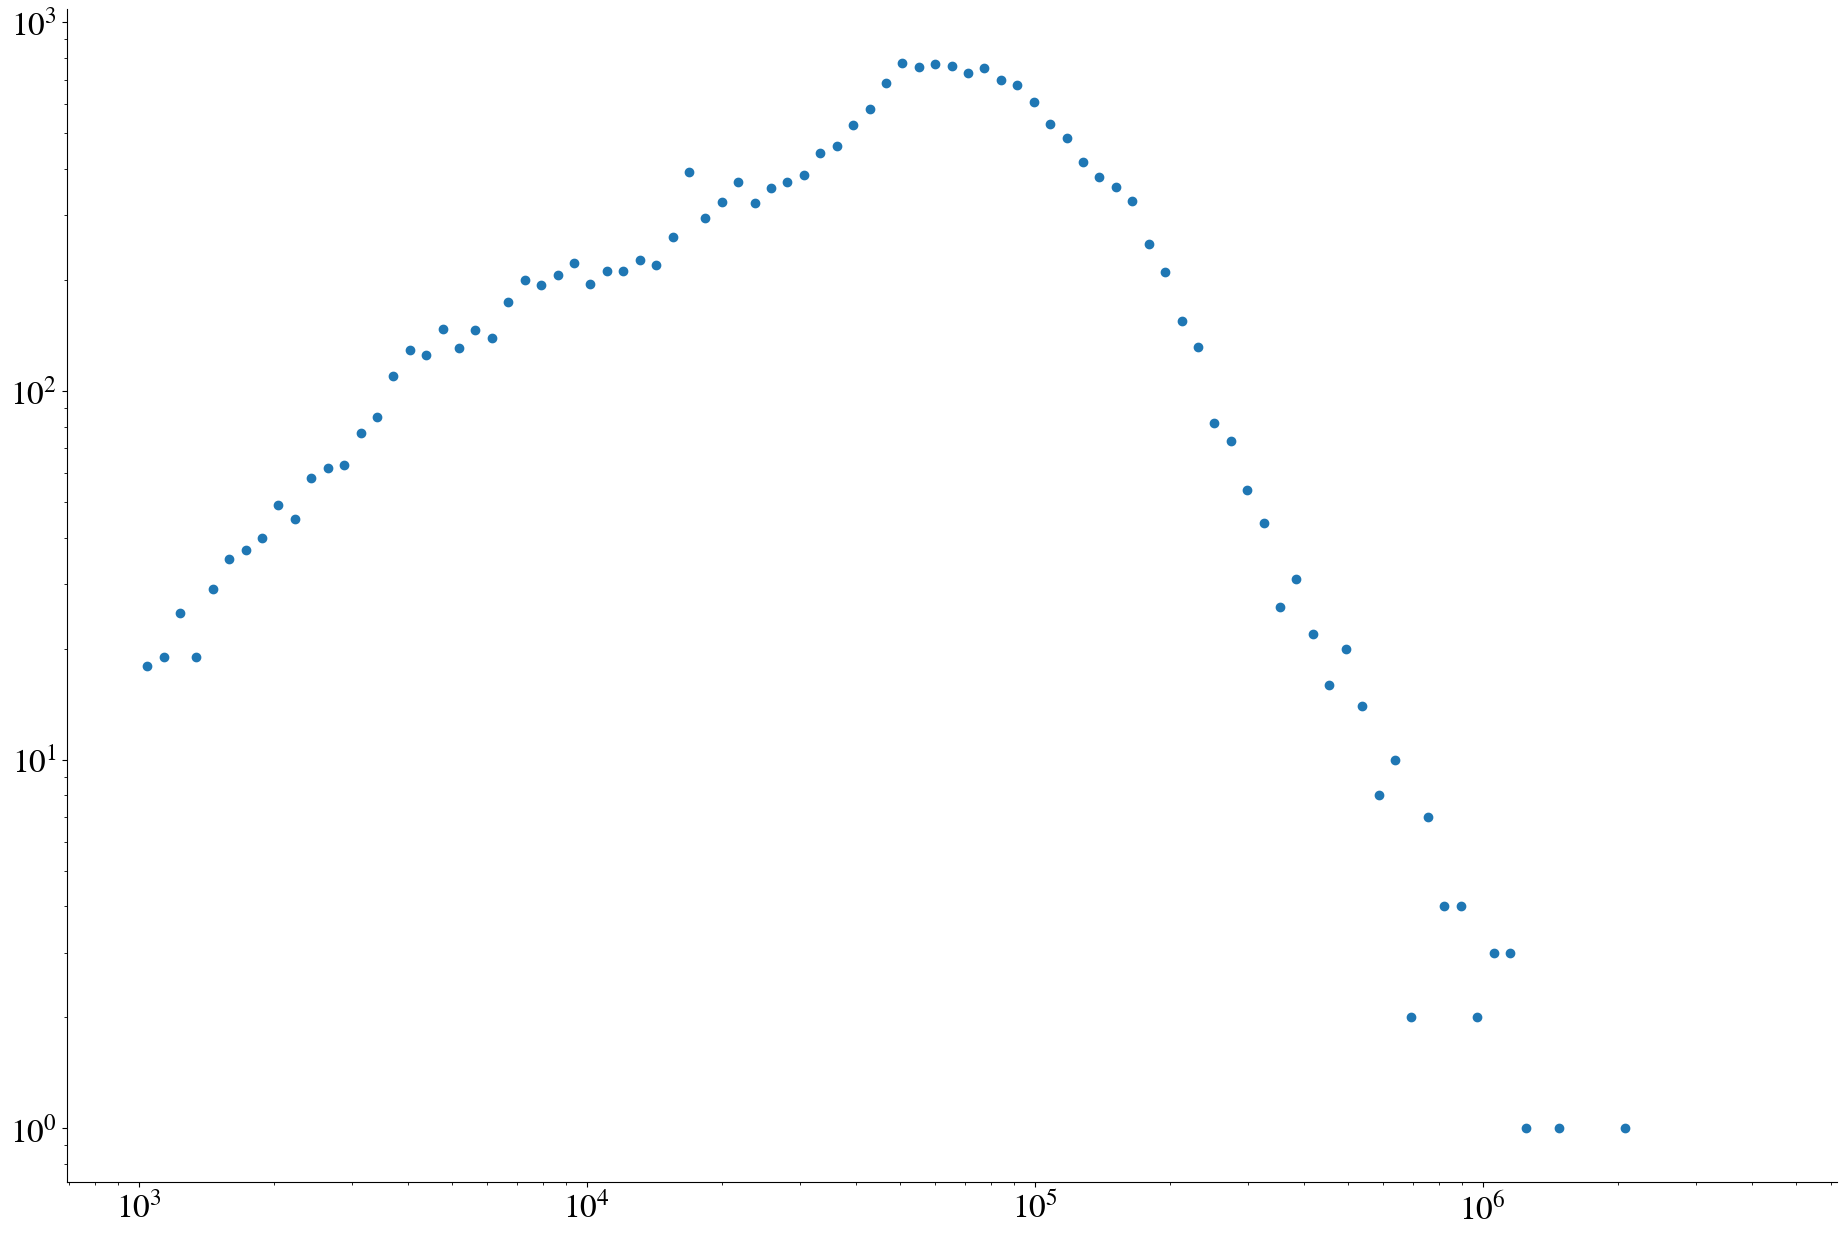

In [93]:
len_sequences = {}
len_sequences_to_sort = []
num_books = len(len_books) # len(all_books)
# for ID, book in tqdm(all_books.items()):
#     sequence = book["sequence_words"]
#     sequence_labels = book["sequence_stems"]
#     len_sequences[ID] = len(sequence)
#     len_sequences_to_sort.append((len(sequence), ID))
for ID, len_book in tqdm(len_books.items()):
    len_sequences[ID] = len_book
    len_sequences_to_sort.append((len_book, ID))
len_sequences_sorted = sorted(len_sequences_to_sort)
for i in range(11):
    print(f'Excluding %d%% len is %d'%(i*10, len_sequences_sorted[int(i/10*(num_books-1))][0]))
vals, bin_edges = np.histogram(list(len_sequences.values()), bins = np.geomspace(min_len_sequence,2*max(list(len_sequences.values())), 100))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.scatter(bin_centers, vals)
plt.loglog()

[]

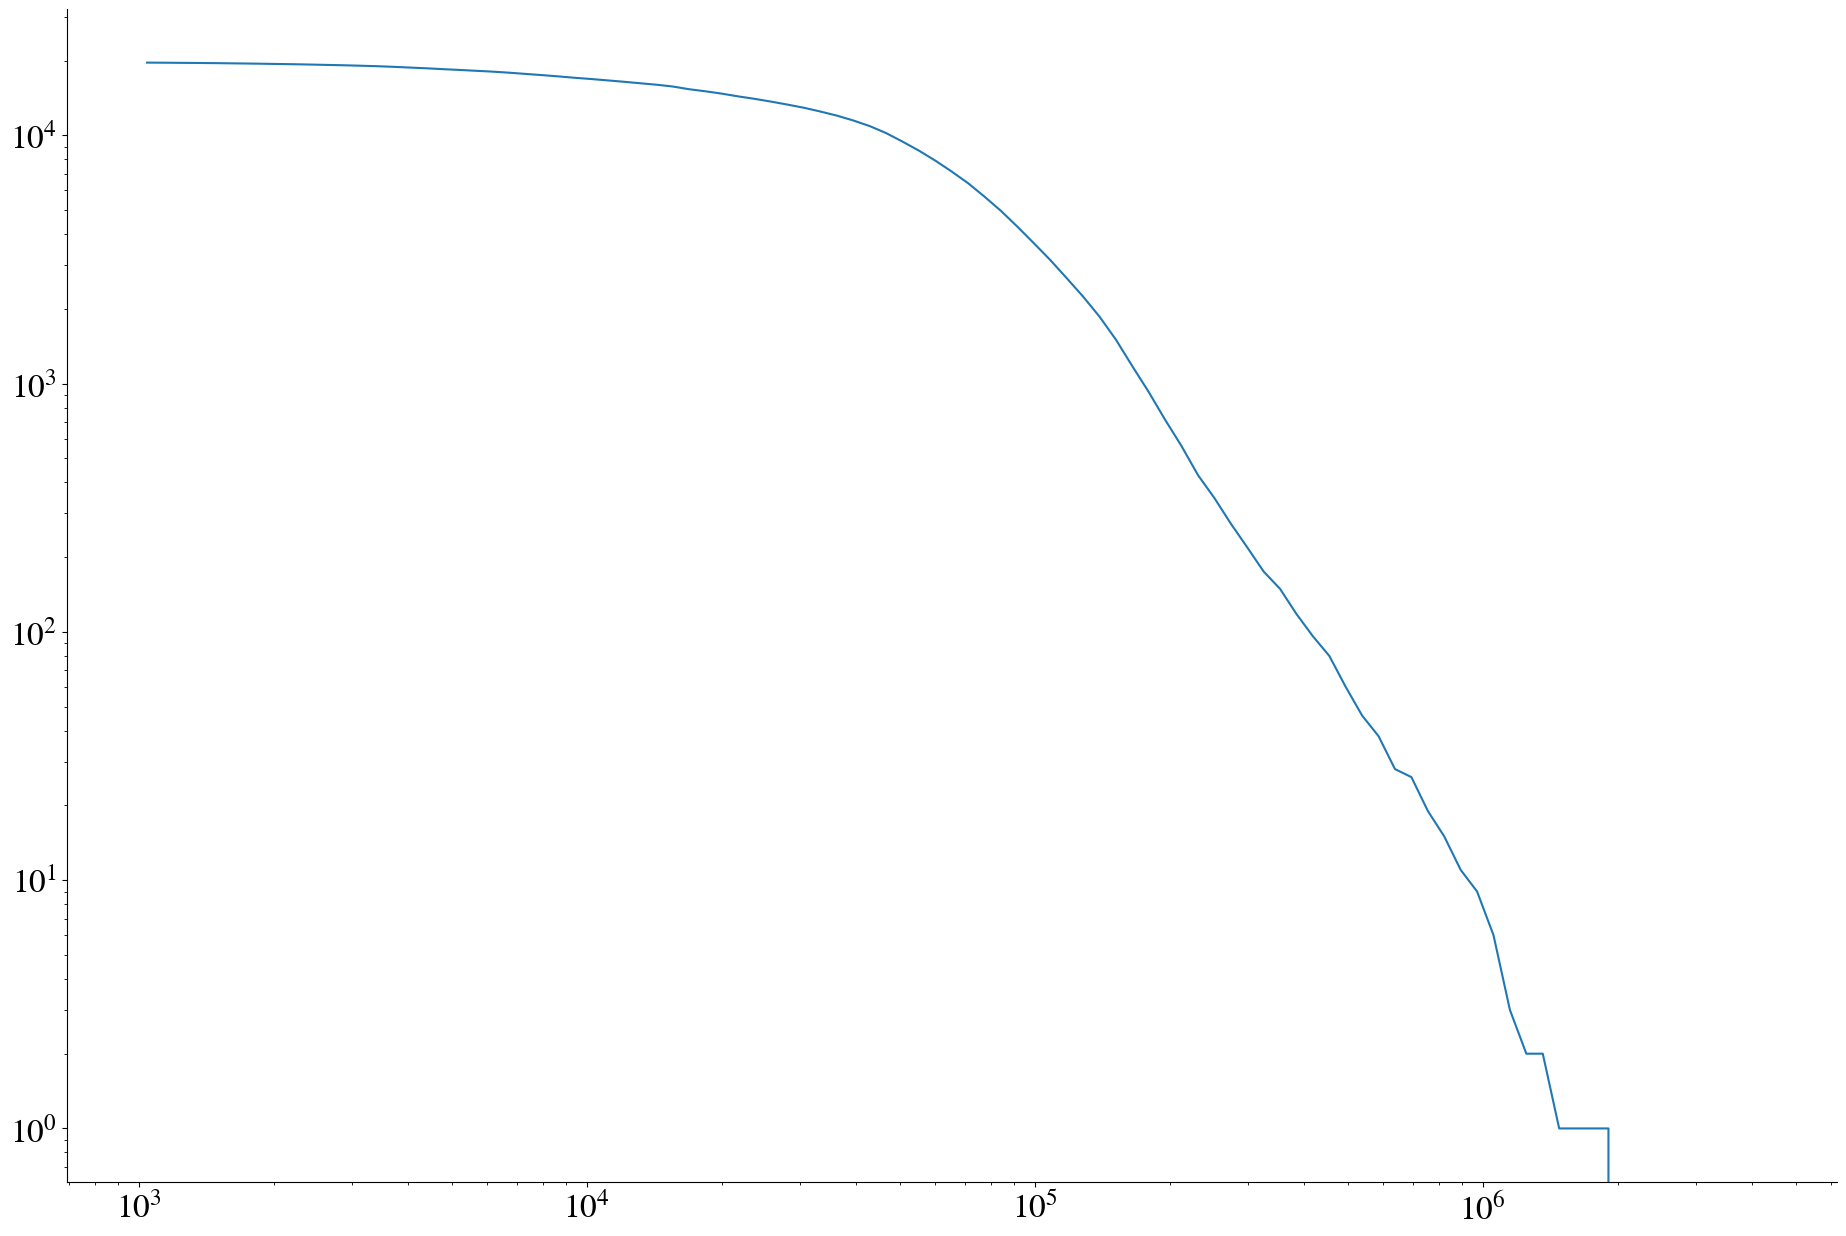

In [94]:
cum = 0
cum_vals = []
sum_vals = sum(vals)
for val in vals:
    cum += val
    cum_vals.append(sum_vals - cum)
plt.plot(bin_centers, cum_vals)
plt.loglog()

In [95]:
median_len_sequences = int(np.round(np.median(list(len_sequences.values()))))
print("Median len of the sequences is",median_len_sequences)

Median len of the sequences is 50726


In [96]:
average_book = {
    'D': [], 
    'D2': [], 
    'D3': [], 
    'D4': [], 
}
problematic = []
count = 0
for ID in tqdm(book_ids):
    try:
        save_all_file_path = os.path.join(analysis_folder, f"individual_results", f"{ID}.pkl")
        save_light_file_path = os.path.join(analysis_folder, f"individual_results_light", f"{ID}_light.pkl")
        if len_books[ID] > median_len_sequences:
            with open(save_all_file_path, 'rb') as fp:
                book_result = pickle.load(fp)
            count += 1
            average_book['D'].append(book_result['D'][:median_len_sequences])
            average_book['D2'].append(book_result['D2'][:median_len_sequences])
            average_book['D3'].append(book_result['D3'][:median_len_sequences])
            average_book['D4'].append(book_result['D4'][:median_len_sequences])
    except FileNotFoundError:
        problematic.append(ID)
print(problematic)
for key in ['D', 'D2', 'D3', 'D4']:
    average_book[key] = np.array(average_book[key])
    mean = np.mean(average_book[key], axis=0)
    std = np.std(average_book[key], axis=0)
    average_book[key+'_plus_std'] = mean + std
    average_book[key+'_minus_std'] = mean - std
    average_book[key+'_25_percentile'] = np.percentile(average_book[key], 25, axis=0)
    average_book[key+'_50_percentile'] = np.percentile(average_book[key], 50, axis=0)
    average_book[key+'_75_percentile'] = np.percentile(average_book[key], 75, axis=0)
    average_book[key] = mean

print(count)

  0%|          | 0/19637 [00:00<?, ?it/s]

[]
9818


In [97]:
D = average_book['D']
D2 = average_book['D2']
D3 = average_book['D3']
D4 = average_book['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join(analysis_folder, f"average_individual_results_light.pkl")
save_all_file_path = os.path.join(analysis_folder, f"average_individual_results.pkl")
average_results_gutenberg = analyse_sequence(None, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = True)
os.remove(save_light_file_path)
for key in average_book.keys():
    average_results_gutenberg[key] = average_book[key]
with open(save_all_file_path,'wb') as fp:
    pickle.dump(average_results_gutenberg,fp)

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [98]:
average_book_stems = {
    'D': [], 
    'D2': [], 
    'D3': [], 
    'D4': [], 
}
problematic_stems = []
count = 0
for ID in tqdm(book_ids):
    try:
        save_all_file_path = os.path.join(analysis_folder, f"individual_results_stems", f"{ID}.pkl")
        save_light_file_path = os.path.join(analysis_folder, f"individual_results_stems_light", f"{ID}_light.pkl")
        if len_books[ID] > median_len_sequences:
            with open(save_all_file_path, 'rb') as fp:
                book_result = pickle.load(fp)
            count += 1
            average_book_stems['D'].append(book_result['D'][:median_len_sequences])
            average_book_stems['D2'].append(book_result['D2'][:median_len_sequences])
            average_book_stems['D3'].append(book_result['D3'][:median_len_sequences])
            average_book_stems['D4'].append(book_result['D4'][:median_len_sequences])
    except FileNotFoundError:
        problematic_stems.append(ID)
print(problematic_stems)
for key in ['D', 'D2', 'D3', 'D4']:
    average_book_stems[key] = np.array(average_book_stems[key])
    mean = np.mean(average_book_stems[key], axis=0)
    std = np.std(average_book_stems[key], axis=0)
    average_book_stems[key+'_plus_std'] = mean + std
    average_book_stems[key+'_minus_std'] = mean - std
    average_book_stems[key+'_25_percentile'] = np.percentile(average_book_stems[key], 25, axis=0)
    average_book_stems[key+'_50_percentile'] = np.percentile(average_book_stems[key], 50, axis=0)
    average_book_stems[key+'_75_percentile'] = np.percentile(average_book_stems[key], 75, axis=0)
    average_book_stems[key] = mean

print(count)

  0%|          | 0/19637 [00:00<?, ?it/s]

[]
9818


In [99]:
len(average_book_stems['D3_75_percentile'])

50726

In [100]:
D = average_book_stems['D']
D2 = average_book_stems['D2']
D3 = average_book_stems['D3']
D4 = average_book_stems['D4']
save_light_file_path = os.path.join(analysis_folder, f"average_individual_results_stems_light.pkl")
save_all_file_path = os.path.join(analysis_folder, f"average_individual_results_stems.pkl")
average_results_gutenberg_stems = analyse_sequence(None, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = True)
os.remove(save_light_file_path)
for key in average_book_stems.keys():
    average_results_gutenberg_stems[key] = average_book_stems[key]
with open(save_all_file_path,'wb') as fp:
    pickle.dump(average_results_gutenberg_stems,fp)

## Collective analysis

In [7]:
with gzip.open(os.path.join(analysis_folder, "all_books_preprocessed.pkl.gz"), "rb") as fp:
    all_books = joblib.load(fp)

In [25]:
print(datetime.now())
sequence = []
randomized_list_all_book_keys = list(all_books.keys()).copy()
random.shuffle(randomized_list_all_book_keys)
for ID in tqdm(randomized_list_all_book_keys):
    book = all_books[ID]
    sequence += list(book["sequence_words"])
sequence = np.array(sequence)

  1%|          | 110/19637 [00:00<00:17, 1089.44it/s]

2023-07-12 08:25:03.030500


100%|██████████| 19637/19637 [00:12<00:00, 1563.65it/s]


In [8]:
scratch_folder = '/data/scratch/ahw701/pairs_petralia/github/data/gutenberg/analysis/'

In [10]:
os.makedirs(os.path.join(scratch_folder, f"randomized_collective_sequences"), exist_ok = True)
os.makedirs(os.path.join(scratch_folder, f"randomized_collective_sequences_labels"), exist_ok = True)

In [11]:
for random_ID in tqdm(range(100)):
    sequence = []
    sequence_labels = []
    randomized_list_all_book_keys = list(all_books.keys()).copy()
    random.Random(random_ID).shuffle(randomized_list_all_book_keys)
    for ID in randomized_list_all_book_keys:
        book = all_books[ID]
        sequence += list(book["sequence_words"])
    sequence = np.array(sequence)
    with open(os.path.join(scratch_folder, f"randomized_collective_sequences", f'{random_ID}.pkl'), 'wb') as fp:
        joblib.dump(sequence, fp)

100%|██████████| 100/100 [3:13:09<00:00, 115.89s/it] 


In [34]:
for random_ID in tqdm(range(100)):
    sequence = []
    sequence_labels = []
    randomized_list_all_book_keys = list(all_books.keys()).copy()
    random.Random(random_ID).shuffle(randomized_list_all_book_keys)
    for ID in randomized_list_all_book_keys:
        book = all_books[ID]
        sequence_labels += list(book["sequence_stems"])
    sequence_labels = np.array(sequence_labels)
    with open(os.path.join(scratch_folder, f"randomized_collective_sequences_labels", f'{random_ID}.pkl'), 'wb') as fp:
        joblib.dump(sequence_labels, fp)

100%|██████████| 94/94 [6:12:02<00:00, 237.47s/it]  


In [12]:
save_light_file_path = os.path.join(analysis_folder, f"collective_results_light.pkl")
save_all_file_path = os.path.join(analysis_folder, f"collective_results.pkl")

results_light_collective_gutenberg = analyse_sequence(sequence, num_to_save=1000, 
                     calculate_entropies_original = False, calculate_entropies_labels = False,
                     D=None, D2=None, D3=None, D4=None, 
                     do_also_D2 = True, do_also_D3 = True, do_also_D4 = False, sequence_labels = None,
                     save_all=True, save_all_file_path = save_all_file_path, 
                     save_light_file_path = save_light_file_path,
                     save_entropies_file_path = "old_to_delete.entropy",
                     calculate_beta_loglogregr_indices = False,
                     do_prints = True, return_all = False)

100%|██████████| 1315357523/1315357523 [44:45<00:00, 489846.91it/s] 


Sorted indices to save at 2023-07-06 18:35:24.856035
Doing beta_mean_indices at 2023-07-06 18:35:24.866684
Doing geom points loglogregr at 2023-07-06 18:35:24.908824
Saving at 2023-07-06 18:35:35.097188
Finished analysis at 2023-07-06 18:37:15.024534


In [13]:
print(datetime.now())
sequence_labels = []
randomized_list_all_book_keys = list(all_books.keys()).copy()
random.shuffle(randomized_list_all_book_keys)
for ID in tqdm(randomized_list_all_book_keys):
    book = all_books[ID]
    sequence_labels += list(book["sequence_stems"])
sequence_labels = np.array(sequence_labels)

  0%|          | 77/19637 [00:00<00:28, 683.76it/s]

2023-07-06 18:42:17.854267


100%|██████████| 19637/19637 [00:22<00:00, 885.21it/s] 


In [14]:
save_light_file_path = os.path.join(analysis_folder, f"collective_results_stems_light.pkl")
save_all_file_path = os.path.join(analysis_folder, f"collective_results_stems.pkl")

results_light_collective_stems_gutenberg = analyse_sequence(sequence_labels, num_to_save=1000, 
                     calculate_entropies_original = False, calculate_entropies_labels = False,
                     D=None, D2=None, D3=None, D4=None, 
                     do_also_D2 = True, do_also_D3 = True, do_also_D4 = False, sequence_labels = None,
                     save_all=True, save_all_file_path = save_all_file_path, 
                     save_light_file_path = save_light_file_path,
                     save_entropies_file_path = "old_to_delete.entropy",
                     calculate_beta_loglogregr_indices = False,
                     do_prints = True, return_all = False)

100%|██████████| 1315357523/1315357523 [43:55<00:00, 499132.43it/s] 


Sorted indices to save at 2023-07-06 22:28:43.487515
Doing beta_mean_indices at 2023-07-06 22:28:43.497166
Doing geom points loglogregr at 2023-07-06 22:28:43.539592
Saving at 2023-07-06 22:28:53.496193
Finished analysis at 2023-07-06 22:30:32.882039


# Semantic Scholar dataset

Created in ./semanticscholar/dataset_creation.ipynb

In [12]:
corpus_version = '2022-01-01'
data_folder = os.path.join('./data/semanticscholar',corpus_version, 'data')
analysis_folder = os.path.join('./data/semanticscholar',corpus_version, 'analysis')

In [13]:
with open(os.path.join(data_folder,'all_fieldsOfStudy.tsv'), 'r', newline='\n') as fp:
    tsv_output = csv.reader(fp, delimiter='\n')
    all_fieldsOfStudy = [] 
    for _ in tsv_output:
        all_fieldsOfStudy.append(_[0])

In [14]:
all_fieldsOfStudy

['Art',
 'Biology',
 'Business',
 'Chemistry',
 'Computer Science',
 'Economics',
 'Engineering',
 'Environmental Science',
 'Geography',
 'Geology',
 'History',
 'Materials Science',
 'Mathematics',
 'Medicine',
 'Philosophy',
 'Physics',
 'Political Science',
 'Psychology',
 'Sociology']

## By field of study and journal

In [18]:
analysis_folder = os.path.join('./data/semanticscholar',corpus_version, 'analysis')
os.makedirs(analysis_folder,exist_ok = True)

In [19]:
num_journals = 1000

### Individual analysis

In [ ]:
all_fieldsOfStudy = ['Computer Science']

In [ ]:
results_light_individual_journals_fieldsOfStudy = {}
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
        
    results_light_individual_journals_fieldsOfStudy[fieldOfStudy] = {}
    for path in tqdm(journals_filepaths):
        sequence = [] 
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
        sequence_labels = sequence.copy()
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_light_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        save_all_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        save_entropies_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_entropy',fieldOfStudy,file_name + '.pkl')
        results_light_individual_journals_fieldsOfStudy[fieldOfStudy][file_name] = analyse_sequence(sequence, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         save_entropies_file_path = save_entropies_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [ ]:
with gzip.open(os.path.join(analysis_folder, 'journals_fieldsOfStudy', 'results_light_texts.pkl.gz'), 'wb') as fp:
    joblib.dump(results_light_individual_journals_fieldsOfStudy, fp)

In [ ]:
results_light_individual_journals_fieldsOfStudy_stems = {}
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy_stems',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
        
    results_light_individual_journals_fieldsOfStudy_stems[fieldOfStudy] = {}
    for path in tqdm(journals_filepaths):
        sequence = [] 
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
        sequence_labels = sequence.copy()
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_light_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_stems',fieldOfStudy,file_name + '.pkl')
        save_all_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_stems',fieldOfStudy,file_name + '.pkl')
        save_entropies_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_entropy_stems',fieldOfStudy,file_name + '.pkl')
        results_light_individual_journals_fieldsOfStudy_stems[fieldOfStudy][file_name] = analyse_sequence(sequence, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         save_entropies_file_path = save_entropies_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [13]:
with gzip.open(os.path.join(analysis_folder, 'journals_fieldsOfStudy_stems', 'results_light_stems.pkl.gz'), 'wb') as fp:
    joblib.dump(results_light_individual_journals_fieldsOfStudy_stems, fp)

In [ ]:
len_journals = {}
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    journal_2_len[fieldOfStudy] = {}
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
    for path in tqdm(journals_filepaths):
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_light_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_light',fieldOfStudy,file_name + '.pkl')
        if os.path.exists(save_light_file_path) == False:
            save_light_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_light',fieldOfStudy,file_name + '_light.pkl')
        with open(save_light_file_path, 'rb') as fp:
            result = pickle.load(fp)
        len_journals[fieldOfStudy][file_name] = result['ts'][-1]

In [ ]:
with gzip.open(os.path.join(analysis_folder, 'len_journals.pkl.gz'), 'wb') as fp:
    joblib.dump(len_journals, fp)

### Average individual analysis

In [115]:
data_folder = os.path.join('./data/semanticscholar',corpus_version, 'data')
analysis_folder = os.path.join('./data/semanticscholar',corpus_version, 'analysis')
os.makedirs(analysis_folder,exist_ok = True)

In [105]:
min_len_sequence = 1000

In [106]:
with gzip.open(os.path.join(analysis_folder, 'len_journals.pkl.gz'), "rb") as fp:
    len_journals = joblib.load(fp)

This is done across fields of study

  0%|          | 0/19 [00:00<?, ?it/s]

[]

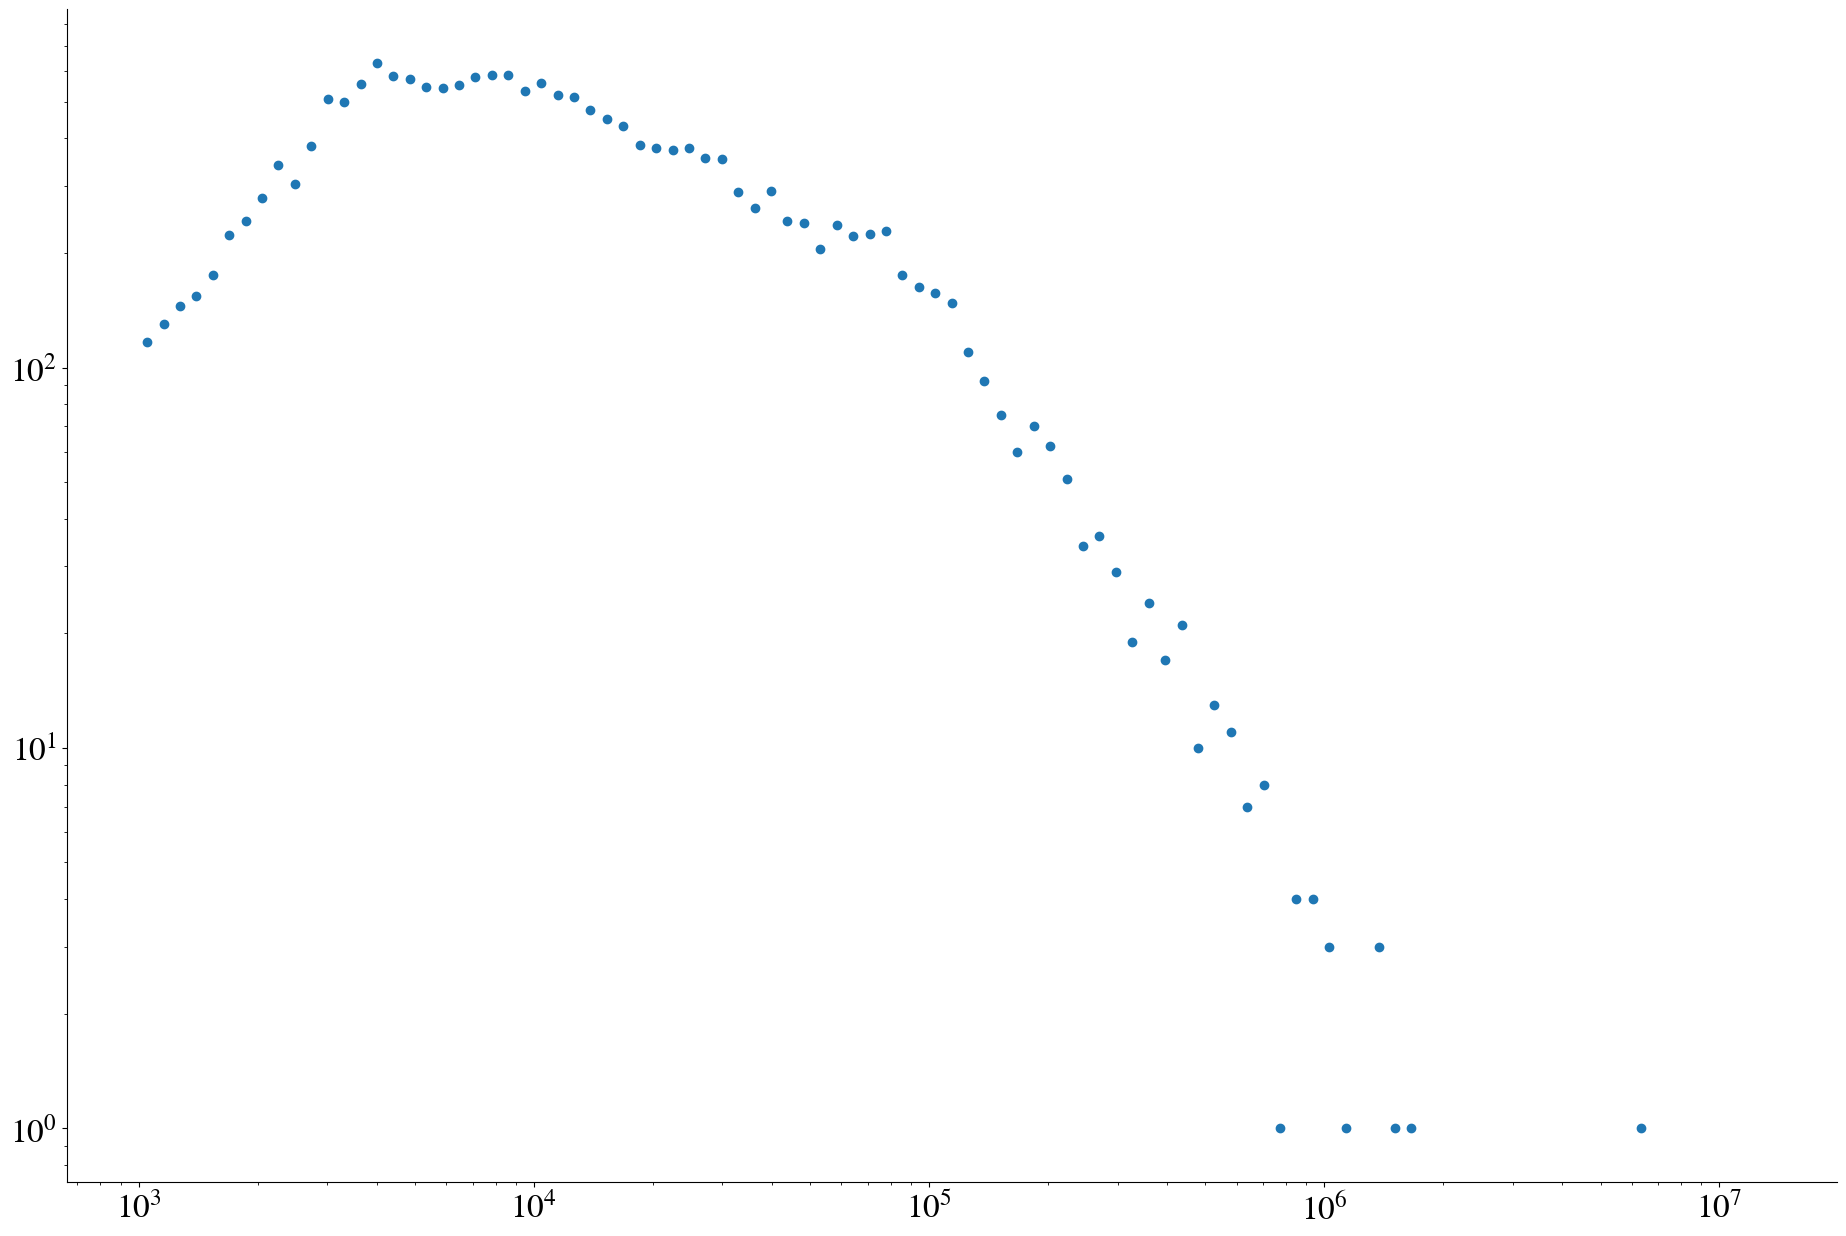

In [107]:
len_sequences = []
for fieldOfStudy,length_dict in tqdm(len_journals.items()):
    for length in length_dict.values():
        len_sequences.append(length)
vals, bin_edges = np.histogram(list(len_sequences), bins = np.geomspace(min_len_sequence,2*max(list(len_sequences)), 100))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.scatter(bin_centers, vals)
plt.loglog()

In [113]:
median_len_sequences = int(np.round(np.median(list(len_sequences))))
print("Median len of the sequences is",median_len_sequences)

Median len of the sequences is 9114


In [127]:
average_journal = {
    'D': [], 
    'D2': [], 
    'D3': [], 
    'D4': [], 
}
problematic_journals = []
count = 0
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
    for path in tqdm(journals_filepaths):
        try:
            file_name = path[-path[::-1].index('/'):path.index('.tsv')]
            save_all_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
            save_light_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_light',fieldOfStudy,file_name + "_light.pkl")
            with open(save_all_file_path, 'rb') as fp:
                result = pickle.load(fp)
            if len(result['D']) > median_len_sequences:
                count += 1
                average_journal['D'].append(result['D'][:median_len_sequences])
                average_journal['D2'].append(result['D2'][:median_len_sequences])
                average_journal['D3'].append(result['D3'][:median_len_sequences])
                average_journal['D4'].append(result['D4'][:median_len_sequences])
        except FileNotFoundError:
            problematic_journals.append(ID)
print(problematic_journals)
for key in ['D', 'D2', 'D3', 'D4']:
    average_journal[key] = np.array(average_journal[key])
    mean = np.mean(average_journal[key], axis=0)
    std = np.std(average_journal[key], axis=0)
    average_journal[key+'_plus_std'] = mean + std
    average_journal[key+'_minus_std'] = mean - std
    average_journal[key+'_25_percentile'] = np.percentile(average_journal[key], 25, axis=0)
    average_journal[key+'_50_percentile'] = np.percentile(average_journal[key], 50, axis=0)
    average_journal[key+'_75_percentile'] = np.percentile(average_journal[key], 75, axis=0)
    average_journal[key] = mean

print(count)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[]
9500


In [128]:
D = average_journal['D']
D2 = average_journal['D2']
D3 = average_journal['D3']
D4 = average_journal['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join(analysis_folder, 'average_individual_results_light_journals_fieldsOfStudy.pkl')
save_all_file_path = os.path.join(analysis_folder, f"average_individual_results_journals_fieldsOfStudy.pkl")
average_results_journal = analyse_sequence(None, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = True)
os.remove(save_light_file_path)
for key in average_journal.keys():
    average_results_journal[key] = average_journal[key]
with open(save_all_file_path,'wb') as fp:
    pickle.dump(average_results_journal,fp)

In [129]:
average_journal_stems = {
    'D': [], 
    'D2': [], 
    'D3': [], 
    'D4': [], 
}
problematic_journals_stems = []
count = 0
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
    for path in tqdm(journals_filepaths):
        try:
            file_name = path[-path[::-1].index('/'):path.index('.tsv')]
            save_all_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_stems',fieldOfStudy,file_name + '.pkl')
            save_light_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_stems_light',fieldOfStudy,file_name +"_light.pkl")
            with open(save_all_file_path, 'rb') as fp:
                result = pickle.load(fp)
            if len(result['D']) > median_len_sequences:
                count += 1
                average_journal_stems['D'].append(result['D'][:median_len_sequences])
                average_journal_stems['D2'].append(result['D2'][:median_len_sequences])
                average_journal_stems['D3'].append(result['D3'][:median_len_sequences])
                average_journal_stems['D4'].append(result['D4'][:median_len_sequences])
        except FileNotFoundError:
            problematic_journals_stems.append(ID)
print(problematic_journals_stems)
for key in ['D', 'D2', 'D3', 'D4']:
    average_journal_stems[key] = np.array(average_journal_stems[key])
    mean = np.mean(average_journal_stems[key], axis=0)
    std = np.std(average_journal_stems[key], axis=0)
    average_journal_stems[key+'_plus_std'] = mean + std
    average_journal_stems[key+'_minus_std'] = mean - std
    average_journal_stems[key+'_25_percentile'] = np.percentile(average_journal_stems[key], 25, axis = 0)
    average_journal_stems[key+'_50_percentile'] = np.percentile(average_journal_stems[key], 50, axis = 0)
    average_journal_stems[key+'_75_percentile'] = np.percentile(average_journal_stems[key], 75, axis = 0)
    average_journal_stems[key] = mean

print(count)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[]
9500


In [130]:
D = average_journal_stems['D']
D2 = average_journal_stems['D2']
D3 = average_journal_stems['D3']
D4 = average_journal_stems['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join(analysis_folder, 'average_individual_results_light_journals_fieldsOfStudy_stems.pkl')
save_all_file_path = os.path.join(analysis_folder, f"average_individual_results_journals_fieldsOfStudy_stems.pkl")
average_results_journal_stems = analyse_sequence(None, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = True)
os.remove(save_light_file_path)
for key in average_journal_stems.keys():
    average_results_journal_stems[key] = average_journal_stems[key]
with open(save_all_file_path,'wb') as fp:
    pickle.dump(average_results_journal_stems,fp)

### Collective analysis

#### Get randomized sequences

In [24]:
scratch_folder = '/data/scratch/ahw701/pairs_petralia/github/data/semanticscholar/2022-01-01/analysis/'

In [16]:
os.makedirs(os.path.join(scratch_folder, f"randomized_collective_sequences"), exist_ok = True)
os.makedirs(os.path.join(scratch_folder, f"randomized_collective_sequences_labels"), exist_ok = True)

In [ ]:
print(datetime.now())
for random_ID in tqdm(range(100)):
    sequence = []
    randomized_journals_filepaths = []
    for fieldOfStudy in all_fieldsOfStudy:
        fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
        journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
        if len(journals_filepaths) != num_journals:
            print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
            break
        randomized_journals_filepaths += journals_filepaths
    random.Random(random_ID).shuffle(randomized_journals_filepaths)
    for path in randomized_journals_filepaths:
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
    sequence = np.array(sequence)
    with open(os.path.join(scratch_folder, f"randomized_collective_sequences", f'{random_ID}.pkl'), 'wb') as fp:
        joblib.dump(sequence, fp)
print(datetime.now())

  0%|          | 0/100 [00:00<?, ?it/s]

2023-07-12 18:27:06.699524


  1%|          | 1/100 [12:27<20:32:45, 747.13s/it]

In [27]:
print(datetime.now())
for random_ID in tqdm(range(100)):
    if random_ID < 37:
        continue
    sequence_labels = []
    randomized_journals_filepaths = []
    for fieldOfStudy in all_fieldsOfStudy:
        fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy_stems',fieldOfStudy)
        journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
        if len(journals_filepaths) != num_journals:
            print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
            break
        randomized_journals_filepaths += journals_filepaths
    random.Random(random_ID).shuffle(randomized_journals_filepaths)
    for path in randomized_journals_filepaths:
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence_labels.append(int(_[0]))
    sequence_labels = np.array(sequence_labels)
    with open(os.path.join(scratch_folder, f"randomized_collective_sequences_labels", f'{random_ID}.pkl'), 'wb') as fp:
        joblib.dump(sequence_labels, fp)
print(datetime.now())

  0%|          | 0/100 [00:00<?, ?it/s]

2023-08-28 15:29:42.681365


100%|██████████| 100/100 [6:30:02<00:00, 234.02s/it] 

2023-08-28 21:59:44.932421


## By field of study and author

### Individual analysis

In [40]:
data_folder = os.path.join('./data/semanticscholar',corpus_version, 'data')
analysis_folder = os.path.join('./data/semanticscholar',corpus_version, 'analysis')
os.makedirs(analysis_folder,exist_ok = True)

In [ ]:
results_light_individual_authors_fieldsOfStudy = {}
num_authors = 1000
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'authors_fieldsOfStudy',fieldOfStudy)
    authors_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(authors_filepaths) != num_authors:
        print(f'Error! Found {len(authors_filepaths)} authors for {fieldOfStudy} instead of {num_authors}')
        break
        
    results_light_individual_authors_fieldsOfStudy[fieldOfStudy] = {}
    for path in tqdm(authors_filepaths):
        sequence = [] 
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
        sequence_labels = sequence.copy()
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_light_file_path = os.path.join(analysis_folder, 'authors_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        save_all_file_path = os.path.join(analysis_folder, 'authors_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        save_entropies_file_path = os.path.join(analysis_folder, 'authors_fieldsOfStudy_entropy',fieldOfStudy,file_name + '.pkl')
        results_light_individual_authors_fieldsOfStudy[fieldOfStudy][file_name] = analyse_sequence(sequence, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         save_entropies_file_path = save_entropies_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [ ]:
with gzip.open(os.path.join(analysis_folder, 'authors_fieldsOfStudy', 'results_light_individual_authors_fieldsOfStudy.pkl.gz'), 'wb') as fp:
    joblib.dump(results_light_individual_authors_fieldsOfStudy, fp)

In [41]:
with gzip.open(os.path.join(analysis_folder, 'authors_fieldsOfStudy', 'results_light_individual_authors_fieldsOfStudy.pkl.gz'), 'rb') as fp:
    results_light_individual_authors_fieldsOfStudy = joblib.load(fp)

## By author

### Individual analysis

In [116]:
data_folder = os.path.join('./data/semanticscholar',corpus_version, 'data')
analysis_folder = os.path.join('./data/semanticscholar',corpus_version, 'analysis')
os.makedirs(analysis_folder,exist_ok = True)

In [ ]:
num_authors = 10000
authors_folder = os.path.join(data_folder,'authors')
authors_filepaths = sorted(find_pattern('*.tsv', authors_folder))
if len(authors_filepaths) != num_authors:
    print(f'Error! Found {len(authors_filepaths)} authors for {fieldOfStudy} instead of {num_authors}')

results_light_individual_authors = {}
for path in tqdm(authors_filepaths):
    file_name = path[-path[::-1].index('/'):path.index('.tsv')]
    save_light_file_path = os.path.join(analysis_folder, 'authors',file_name + '.pkl')
    if not os.path.exists(save_light_file_path):
        sequence = [] 
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
        sequence_labels = sequence.copy()
        save_all_file_path = os.path.join(analysis_folder, 'authors',file_name + '.pkl')
        save_entropies_file_path = os.path.join(analysis_folder, 'authors_entropy',fieldOfStudy,file_name + '.pkl')
        results_light_individual_authors[file_name] = analyse_sequence(sequence, num_to_save=1000, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         save_entropies_file_path = save_entropies_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [134]:
with gzip.open(os.path.join(analysis_folder, 'authors', 'results_light_individual_authors.pkl.gz'), 'wb') as fp:
    joblib.dump(results_light_individual_authors, fp)

In [ ]:
with gzip.open(os.path.join(analysis_folder, 'authors', 'results_light_individual_authors.pkl.gz'), 'rb') as fp:
    results_light_individual_authors = joblib.load(fp)